In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stroke-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1120859%2F1882037%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T195311Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db915f8af6c33cb8bd18c2bb5242c7b24f688ad6043e1ebfff2468401d83c92d7667750fb0ba1631b3de29c7fe90e136e9e6a2fd62b5edb76535500dc386b4e118e5a349465088ed0bb2c24a3401adcbcc64efbefed882a424aa5f5926be365c163c2ddb0ea3dd709491f2a98e3a68676b73bedbccef5bd8bc03ea757eec68726ecffbaa9af465afe5a4488129b6d248ca2733dbcd6ab073d6afd325f5fa747a479e28c38e94a26080026e8669b60994770d5d53a89004a11922dce9e0ab15b1e8ee0d5114bffe05975e84a584a19a5ff1bf0d717e35682b53656a9d10e205698a181f2a319176469c554395f8bfd1a545a63c423f6eae7e039fe225b5b80b964'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69007 bytes downloaded
Downloaded and uncompressed: stroke-prediction-dataset
Data source import complete.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [6]:
df= pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv').iloc[:,1:]

# **Data Info:**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
print(df.shape)
df.head()

(5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [9]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# **Check Null values & Duplicated:**

In [10]:
df.isnull().sum().sort_values(ascending=False).head() # will be handled later using knnimputer after encoding

,0
bmi,201
gender,0
age,0
hypertension,0
heart_disease,0


<Axes: >

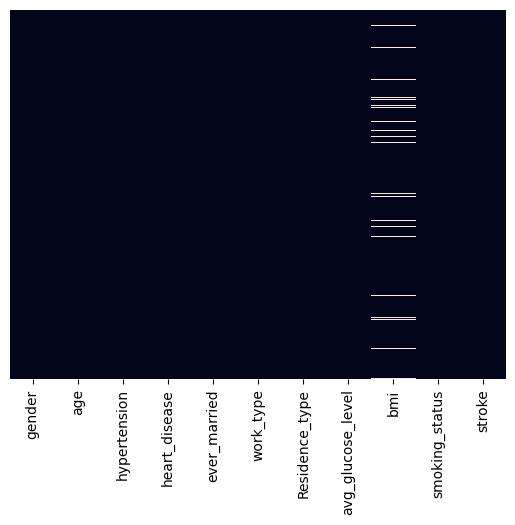

In [11]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)

In [12]:
df.duplicated().sum() #no duplicated values

0

# **Correlations**

age :  0.24525734617097444
hypertension :  0.1279038234664799
heart_disease :  0.1349139969686925
avg_glucose_level :  0.13194544082571003
bmi :  0.04237366114923359


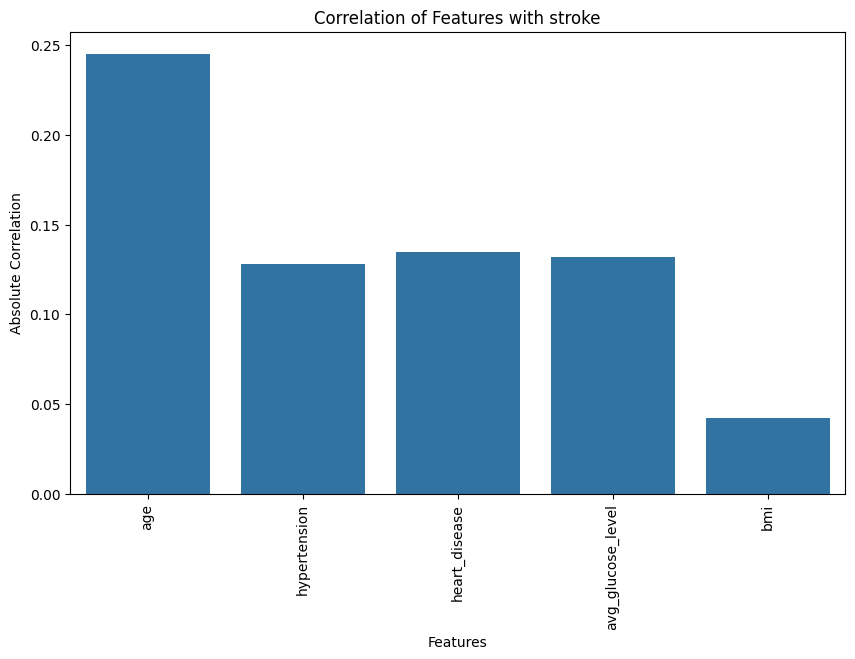

In [13]:
# Select columns of type int or float
obj_cols = df.select_dtypes(include=['int64', 'float64']).columns

key = []
vals = []

# Iterate over numeric columns and compute correlation with 'RiskScore'
for n in obj_cols:
    if n=='stroke':
        continue
    key.append(n)
    vals.append(abs(df['stroke'].corr(df[n])))
    print(n,": ",df['stroke'].corr(df[n]))

# Plot the values
plt.figure(figsize=(10,6))
sns.barplot(x=key, y=vals)
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.title('Correlation of Features with stroke')
plt.ylabel('Absolute Correlation')
plt.xlabel('Features')
plt.show()

In [14]:
df.nunique().sort_values()

,0
hypertension,2
heart_disease,2
ever_married,2
Residence_type,2
stroke,2
gender,3
smoking_status,4
work_type,5
age,104
bmi,418


# **Plots before balancing:**

The plot would not reflect a good view as the data is unbalanced

In [15]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

<Axes: xlabel='heart_disease', ylabel='count'>

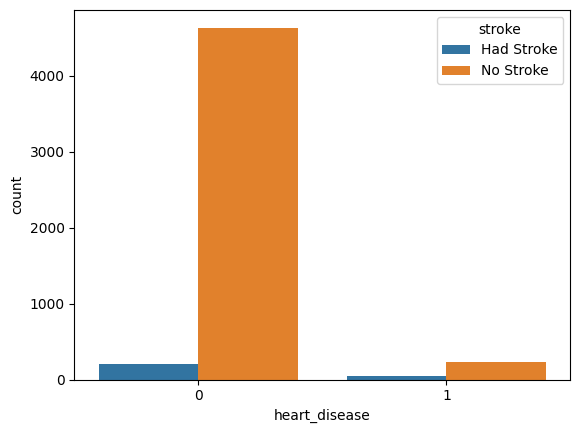

In [16]:
df['stroke']=np.where(df['stroke'] == 1,'Had Stroke','No Stroke')
sns.countplot(x=df['heart_disease'],hue=df['stroke'])

<Axes: xlabel='hypertension', ylabel='count'>

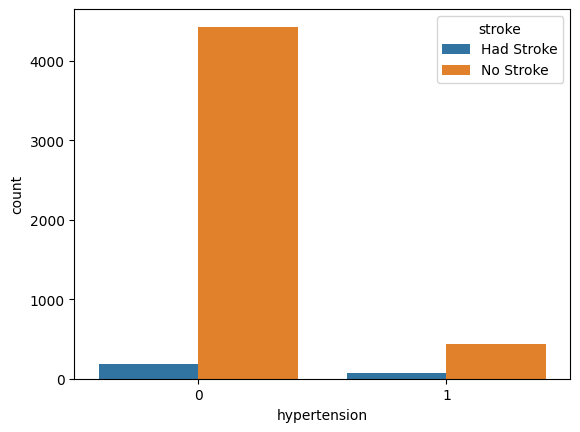

In [17]:
sns.countplot(x=df['hypertension'],hue=df['stroke'])

In [18]:
df['stroke']=np.where(df['stroke'] == 'Had Stroke',1,0) # return it back to numeric values


# **Encoding:**

In [19]:
from sklearn.preprocessing import LabelEncoder
obj_cols=df.select_dtypes('object').columns
obj_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [20]:
for c in obj_cols:
    lb =LabelEncoder()
    df.loc[:,c]= lb.fit_transform(df[c])
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1


# **Handling Nan values:**

In [21]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df['bmi']=imputer.fit_transform(df[['bmi']])
df.isnull().sum().sort_values(ascending=False).head()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0


# **Data splitting and scaling:**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [23]:
X=df.drop(['stroke'],axis=1)
y=df['stroke']

In [24]:
X_train , X_test, y_train , y_test= train_test_split (X,y, shuffle= True,
                                                      random_state=42 , test_size=0.3)

In [25]:
scaler= MinMaxScaler(feature_range=(0,1))
scaler.fit(X)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

# **Applying models:**

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_score,accuracy_score,recall_score , f1_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [27]:
mod ={
'LogisticRegression' : LogisticRegression(random_state=42),
'DecisionTreeClassifier' : DecisionTreeClassifier(criterion= 'entropy',max_depth=None),
'RandomForestClassifier' : RandomForestClassifier(n_estimators=20, criterion ='gini',max_depth=None),
'svm': svm.LinearSVC(),
'KNN': KNeighborsClassifier(n_neighbors=5),
'Naive_bayes': GaussianNB()
}

In [28]:
calcs= {
'Models':['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','svm',
'KNN','Naive_bayes'],
'score_train':[],
'score_test':[],
'accuracy_score':[],
'recall':[],
'precision':[],
'f1_score':[],
'cnf_matrix':[]
}

In [29]:
y_pred=[]
k=0
for n in mod :
    mod[n].fit(X_train,y_train)
    y_pred.append(mod[n].predict(X_test))
    calcs['accuracy_score'].append( accuracy_score(y_test,y_pred[k]) )
    calcs['recall'].append( recall_score(y_test,y_pred[k],average='weighted'))
    calcs['precision'].append( precision_score(y_test,y_pred[k],average='weighted') )
    calcs['score_train'].append( mod[n].score(X_train,y_train) )
    calcs['score_test'].append( mod[n].score(X_test,y_test) )
    calcs['f1_score'].append(f1_score(y_test, y_pred[k], average='weighted'))
    calcs['cnf_matrix'].append( metrics.confusion_matrix(y_test, y_pred[k]) )
    k=k+1
calcs

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Models': ['LogisticRegression',
  'DecisionTreeClassifier',
  'RandomForestClassifier',
  'svm',
  'KNN',
  'Naive_bayes'],
 'score_train': [0.9552697791445345,
  1.0,
  0.9972043611965334,
  0.9552697791445345,
  0.9580654179480012,
  0.8714006150405368],
 'score_test': [0.9419439008480104,
  0.9054142204827136,
  0.9406392694063926,
  0.9419439008480104,
  0.9406392694063926,
  0.8649706457925636],
 'accuracy_score': [0.9419439008480104,
  0.9054142204827136,
  0.9406392694063926,
  0.9419439008480104,
  0.9406392694063926,
  0.8649706457925636],
 'recall': [0.9419439008480104,
  0.9054142204827136,
  0.9406392694063926,
  0.9419439008480104,
  0.9406392694063926,
  0.8649706457925636],
 'precision': [0.8872583123447664,
  0.9038986801596351,
  0.8871868746066827,
  0.8872583123447664,
  0.9022453270260505,
  0.9157712363508552],
 'f1_score': [0.9137836700198367,
  0.9046525612135464,
  0.9131314991750125,
  0.9137836700198367,
  0.9143606347241539,
  0.8869647322999251],
 'cnf_mat

In [30]:
models = pd.DataFrame(calcs)
models.sort_values(by='score_test',ascending=False).style.background_gradient(cmap='YlGn')

,Models,score_train,score_test,accuracy_score,recall,precision,f1_score,cnf_matrix
0,LogisticRegression,0.955270,0.941944,0.941944,0.941944,0.887258,0.913784,[[1444 0] [ 89 0]]
3,svm,0.955270,0.941944,0.941944,0.941944,0.887258,0.913784,[[1444 0] [ 89 0]]
2,RandomForestClassifier,0.997204,0.940639,0.940639,0.940639,0.887187,0.913131,[[1442 2] [ 89 0]]
4,KNN,0.958065,0.940639,0.940639,0.940639,0.902245,0.914361,[[1441 3] [ 88 1]]
1,DecisionTreeClassifier,1.000000,0.905414,0.905414,0.905414,0.903899,0.904653,[[1373 71] [ 74 15]]
5,Naive_bayes,0.871401,0.864971,0.864971,0.864971,0.915771,0.886965,[[1290 154] [ 53 36]]


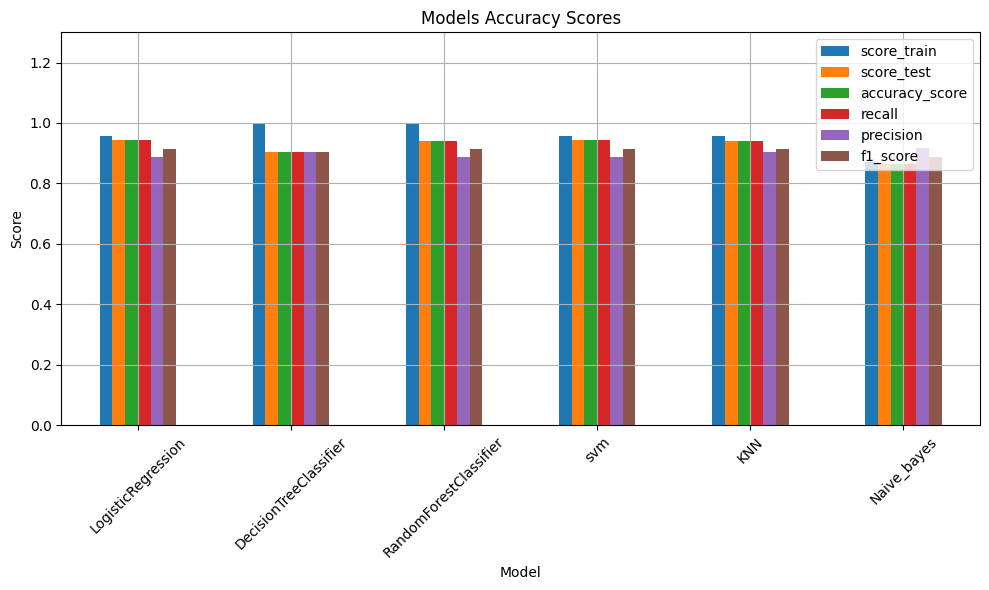

In [31]:
models=models.rename(index={0: 'LogisticRegression', 1:'DecisionTreeClassifier', 2:'RandomForestClassifier',
                    3:'svm', 4:'KNN', 5:'Naive_bayes'})
# Plotting
models.plot(kind='bar', figsize=(10, 6))

# Customizing the plot

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Models Accuracy Scores')
plt.ylim(0,1.3)
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.grid(True)
# Display the plot
plt.show()

In [32]:
target_names = ['Had stroke', 'NO stroke']
for n in range(0,6):
    print("For ",models.index[n],":\n\n",classification_report(y_test, y_pred[n], target_names=target_names))

For  LogisticRegression :

               precision    recall  f1-score   support

  Had stroke       0.94      1.00      0.97      1444
   NO stroke       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

For  DecisionTreeClassifier :

               precision    recall  f1-score   support

  Had stroke       0.95      0.95      0.95      1444
   NO stroke       0.17      0.17      0.17        89

    accuracy                           0.91      1533
   macro avg       0.56      0.56      0.56      1533
weighted avg       0.90      0.91      0.90      1533

For  RandomForestClassifier :

               precision    recall  f1-score   support

  Had stroke       0.94      1.00      0.97      1444
   NO stroke       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Well the results is very high, but the data seems like unbalanced, so let's balance it and see if we can get better accuarcy or not

# **Balance the Data:**

<Axes: xlabel='stroke'>

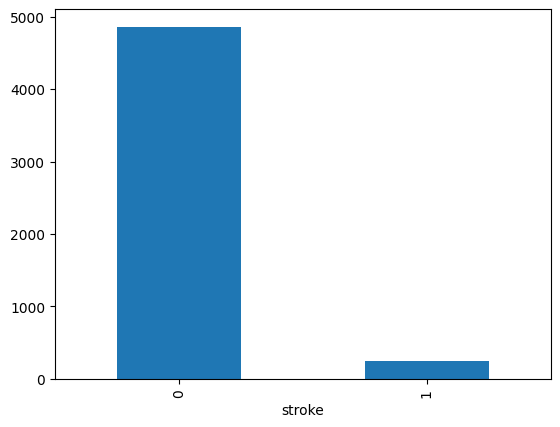

In [33]:
y.value_counts().plot.bar() # before

In [34]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)

In [35]:
X_b,y_b=sm.fit_resample(X,y)

<Axes: xlabel='stroke'>

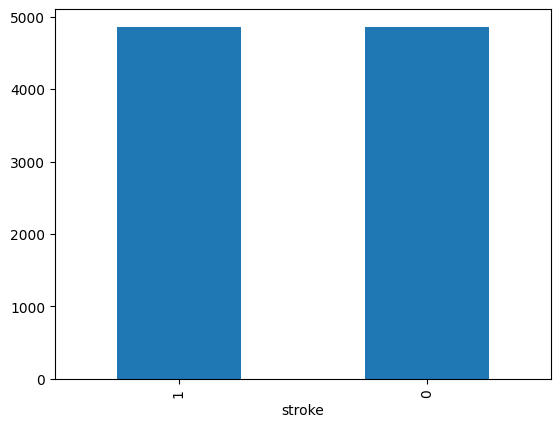

In [36]:
y_b.value_counts().plot.bar() # after

In [37]:
X_b=pd.DataFrame(X_b)
y_b=pd.DataFrame(y_b)
y_b['stroke']

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
9717,1
9718,1
9719,1
9720,1


# **Plots after balancing:**

<Axes: xlabel='heart_disease', ylabel='count'>

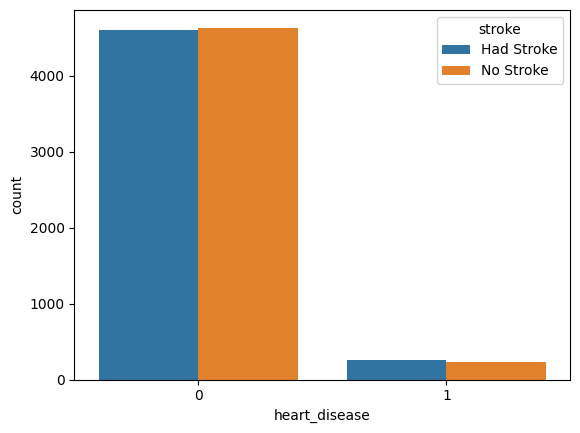

In [38]:
y_b['stroke']=np.where(y_b['stroke'] == 1,'Had Stroke','No Stroke')
sns.countplot(x=X_b['heart_disease'],hue=y_b['stroke'])

<Axes: xlabel='hypertension', ylabel='count'>

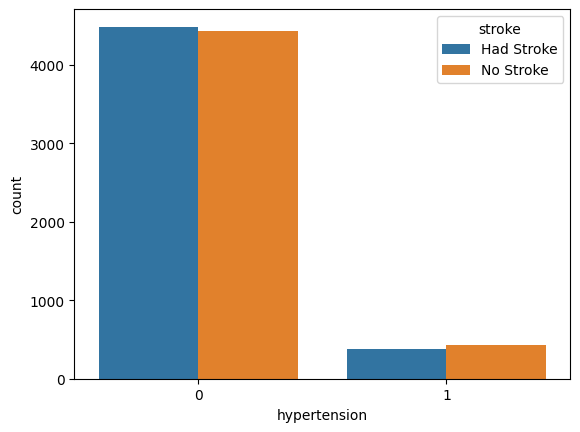

In [39]:
sns.countplot(x=X_b['hypertension'],hue=y_b['stroke'])

In [40]:
y_b['stroke']=np.where(y_b['stroke'] == 'Had Stroke',1,0)
y_b['stroke'].nunique()

2

# **Applying models after balancing:**

In [41]:
X_b.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1.0,67.0,0,1,1.0,2.0,1.0,228.69,36.600000,1.0
1,0.0,61.0,0,0,1.0,3.0,0.0,202.21,28.893237,2.0
2,1.0,80.0,0,1,1.0,2.0,0.0,105.92,32.500000,2.0
3,0.0,49.0,0,0,1.0,2.0,1.0,171.23,34.400000,3.0
4,0.0,79.0,1,0,1.0,3.0,0.0,174.12,24.000000,2.0


In [42]:
# splitting new data:
X_trainb , X_testb, y_trainb , y_testb= train_test_split (X_b,y_b, shuffle= True,
                                                      random_state=42 , test_size=0.3)

In [43]:
#Scaling new data:
scaler= MinMaxScaler(feature_range=(0,1))
scaler.fit(X_b)
X_trainb= scaler.transform(X_trainb)
X_testb= scaler.transform(X_testb)

In [44]:
mod_B ={
'LogisticRegression' : LogisticRegression(random_state=42),
'DecisionTreeClassifier' : DecisionTreeClassifier(criterion= 'entropy',max_depth=None),
'RandomForestClassifier' : RandomForestClassifier(n_estimators=20, criterion ='gini',max_depth=None),
'svm': svm.LinearSVC(),
'KNN': KNeighborsClassifier(n_neighbors=5),
'Naive_bayes': GaussianNB()
}

In [45]:
calcs_B= {
'Models':['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','svm',
'KNN','Naive_bayes'],
'score_train':[],
'score_test':[],
'accuracy_score':[],
'recall':[],
'precision':[],
'f1_score':[],
'cnf_matrix':[]
}

In [46]:
y_pred_B=[]
k=0
for n in mod_B :
    mod_B[n].fit(X_trainb,y_trainb)
    y_pred_B.append(mod_B[n].predict(X_testb))
    calcs_B['accuracy_score'].append( accuracy_score(y_testb,y_pred_B[k]) )
    calcs_B['recall'].append( recall_score(y_testb,y_pred_B[k],average='weighted'))
    calcs_B['precision'].append( precision_score(y_testb,y_pred_B[k],average='weighted') )
    calcs_B['score_train'].append( mod_B[n].score(X_trainb,y_trainb) )
    calcs_B['score_test'].append( mod_B[n].score(X_testb,y_testb) )
    calcs_B['f1_score'].append(f1_score(y_testb, y_pred_B[k], average='weighted'))
    calcs_B['cnf_matrix'].append( metrics.confusion_matrix(y_testb, y_pred_B[k]) )
    k=k+1
calcs_B

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

{'Models': ['LogisticRegression',
  'DecisionTreeClassifier',
  'RandomForestClassifier',
  'svm',
  'KNN',
  'Naive_bayes'],
 'score_train': [0.7785451873622337,
  1.0,
  0.9995591476855253,
  0.7779573842762675,
  0.9423952975753123,
  0.7616458486407054],
 'score_test': [0.780939321220432,
  0.9348645869043538,
  0.9653753856702091,
  0.7843675008570449,
  0.9012684264655468,
  0.7658553308193349],
 'accuracy_score': [0.780939321220432,
  0.9348645869043538,
  0.9653753856702091,
  0.7843675008570449,
  0.9012684264655468,
  0.7658553308193349],
 'recall': [0.780939321220432,
  0.9348645869043538,
  0.9653753856702091,
  0.7843675008570449,
  0.9012684264655468,
  0.7658553308193349],
 'precision': [0.7820232847788092,
  0.9349040163002577,
  0.9661922829091979,
  0.7860677603086913,
  0.9029358091810068,
  0.7765194918299931],
 'f1_score': [0.7807188702366228,
  0.93486276495617,
  0.965360983045386,
  0.7840347914120094,
  0.9011625100462496,
  0.7635421736808111],
 'cnf_matrix': 

In [47]:
models_B = pd.DataFrame(calcs_B)
models_B.sort_values(by='score_test',ascending=False).style.background_gradient(cmap='YlGn')

,Models,score_train,score_test,accuracy_score,recall,precision,f1_score,cnf_matrix
2,RandomForestClassifier,0.999559,0.965375,0.965375,0.965375,0.966192,0.965361,[[1437 20] [ 81 1379]]
1,DecisionTreeClassifier,1.000000,0.934865,0.934865,0.934865,0.934904,0.934863,[[1355 102] [ 88 1372]]
4,KNN,0.942395,0.901268,0.901268,0.901268,0.902936,0.901163,[[1266 191] [ 97 1363]]
3,svm,0.777957,0.784368,0.784368,0.784368,0.786068,0.784035,[[1086 371] [ 258 1202]]
0,LogisticRegression,0.778545,0.780939,0.780939,0.780939,0.782023,0.780719,[[1092 365] [ 274 1186]]
5,Naive_bayes,0.761646,0.765855,0.765855,0.765855,0.776519,0.763542,[[ 972 485] [ 198 1262]]


In [48]:
models = pd.DataFrame(calcs) # for comparison
models.sort_values(by='score_test',ascending=False).style.background_gradient(cmap='YlGn')

,Models,score_train,score_test,accuracy_score,recall,precision,f1_score,cnf_matrix
0,LogisticRegression,0.955270,0.941944,0.941944,0.941944,0.887258,0.913784,[[1444 0] [ 89 0]]
3,svm,0.955270,0.941944,0.941944,0.941944,0.887258,0.913784,[[1444 0] [ 89 0]]
2,RandomForestClassifier,0.997204,0.940639,0.940639,0.940639,0.887187,0.913131,[[1442 2] [ 89 0]]
4,KNN,0.958065,0.940639,0.940639,0.940639,0.902245,0.914361,[[1441 3] [ 88 1]]
1,DecisionTreeClassifier,1.000000,0.905414,0.905414,0.905414,0.903899,0.904653,[[1373 71] [ 74 15]]
5,Naive_bayes,0.871401,0.864971,0.864971,0.864971,0.915771,0.886965,[[1290 154] [ 53 36]]


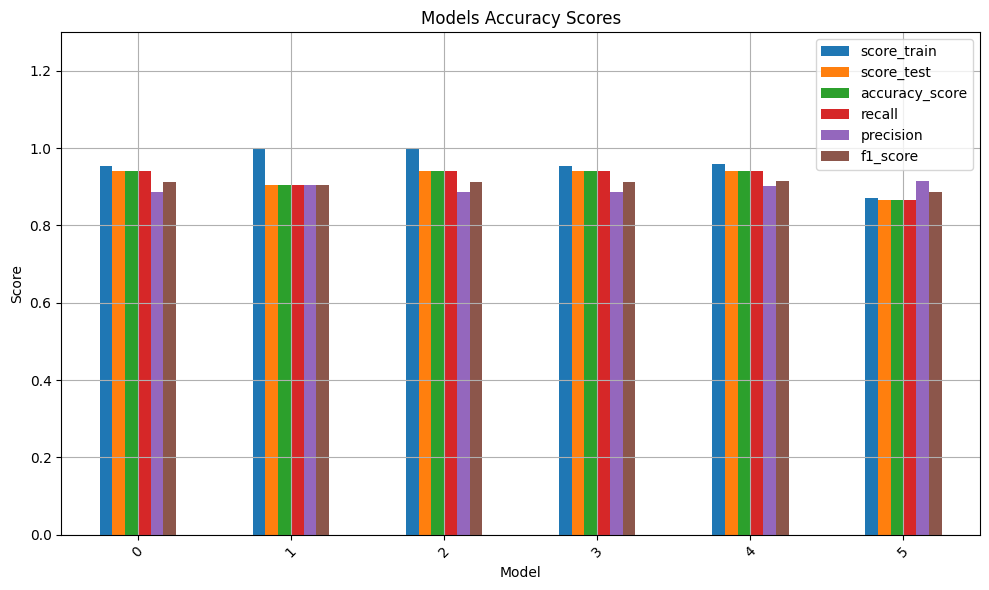

In [49]:
models_B=models_B.rename(index={0: 'LogisticRegression', 1:'DecisionTreeClassifier', 2:'RandomForestClassifier',
                    3:'svm', 4:'KNN', 5:'Naive_bayes'})
# Plotting
models.plot(kind='bar', figsize=(10, 6))

# Customizing the plot

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Models Accuracy Scores')
plt.ylim(0,1.3)
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.grid(True)
# Display the plot
plt.show()

In [50]:
target_names = ['Had stroke', 'NO stroke']
for n in range(0,6):
    print("For ",models_B.index[n],":\n\n",classification_report(y_testb, y_pred_B[n], target_names=target_names))

For  LogisticRegression :

               precision    recall  f1-score   support

  Had stroke       0.80      0.75      0.77      1457
   NO stroke       0.76      0.81      0.79      1460

    accuracy                           0.78      2917
   macro avg       0.78      0.78      0.78      2917
weighted avg       0.78      0.78      0.78      2917

For  DecisionTreeClassifier :

               precision    recall  f1-score   support

  Had stroke       0.94      0.93      0.93      1457
   NO stroke       0.93      0.94      0.94      1460

    accuracy                           0.93      2917
   macro avg       0.93      0.93      0.93      2917
weighted avg       0.93      0.93      0.93      2917

For  RandomForestClassifier :

               precision    recall  f1-score   support

  Had stroke       0.95      0.99      0.97      1457
   NO stroke       0.99      0.94      0.96      1460

    accuracy                           0.97      2917
   macro avg       0.97      0.97   

# **Apply Deep Model:**

In [51]:
import tensorflow as tf
from tensorflow import keras

In [53]:
# Define the model
ker = keras.Sequential()
ker.add(keras.layers.Dense(32,  activation="relu", input_shape = X_trainb.shape[1:]))
ker.add(keras.layers.Dense(16, activation="relu"))
ker.add(keras.layers.Dense(1, activation="sigmoid"))

In [55]:
# Compiling the model
ker.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Training and evaluating the model
history = ker.fit(X_trainb, y_trainb, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5653 - loss: 0.6860 - val_accuracy: 0.7127 - val_loss: 0.6066
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7141 - loss: 0.5939 - val_accuracy: 0.7656 - val_loss: 0.5119
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7614 - loss: 0.5134 - val_accuracy: 0.8016 - val_loss: 0.4545
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7868 - loss: 0.4624 - val_accuracy: 0.8222 - val_loss: 0.4239
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8116 - loss: 0.4299 - val_accuracy: 0.8347 - val_loss: 0.4008
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8101 - loss: 0.4265 - val_accuracy: 0.8347 - val_loss: 0.3891
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - loss: 0.4050 - val_accuracy: 0.8332 - val_loss: 0.3835
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8213 - loss: 0.3960 - val_accuracy: 0.8413 - v

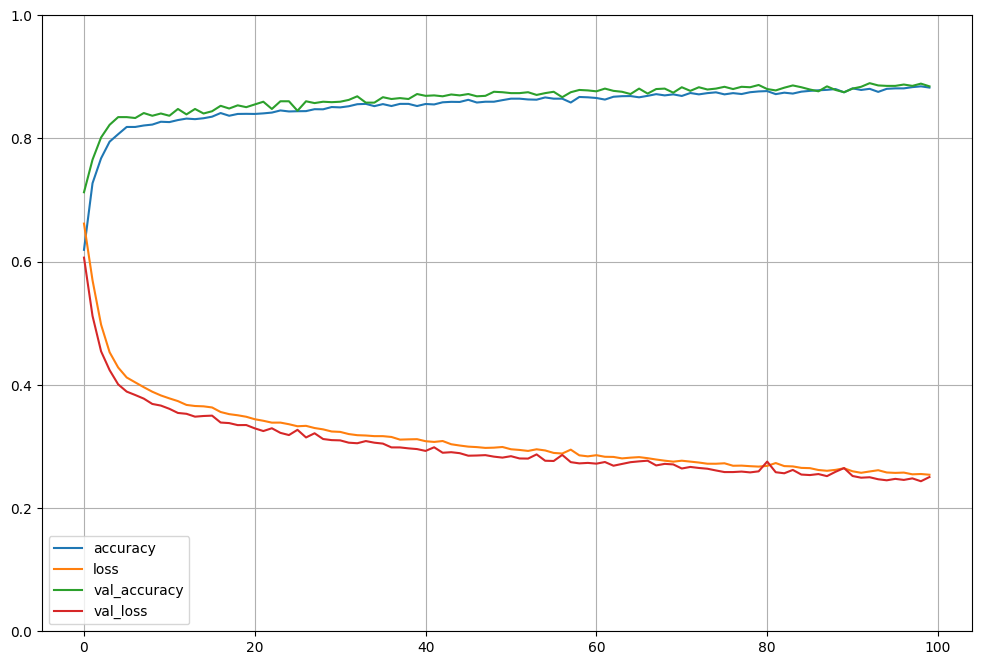

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.2808
Loss     :  0.27668339014053345
accuracy :  0.8724716901779175


In [56]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
model_evaluate = ker.evaluate(X_testb, y_testb)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

In [57]:
ker.predict(X_testb)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.01231279],
       [0.9499691 ],
       [0.60833186],
       ...,
       [0.00774652],
       [0.6120203 ],
       [0.99995667]], dtype=float32)

In [59]:
y_pr = (ker.predict(X_testb) > 0.5).astype("int32").tolist()

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1457
           1       0.91      0.83      0.87      1460

    accuracy                           0.87      2917
   macro avg       0.88      0.87      0.87      2917
weighted avg       0.88      0.87      0.87      2917

Confusion matrix : 

[[1336  121]
 [ 251 1209]]


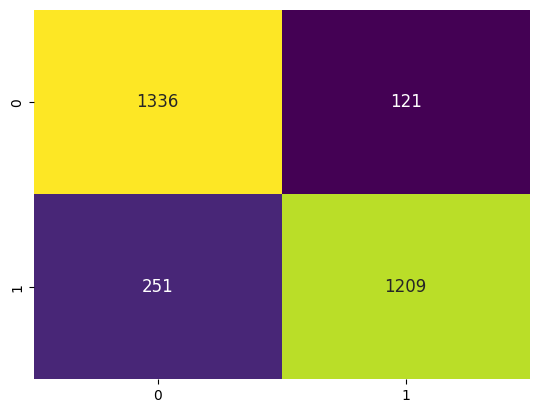

Normalized confusion matrix : 

[[0.92 0.08]
 [0.17 0.83]]


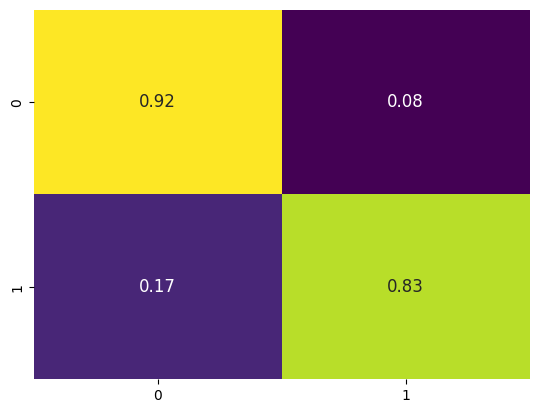

In [60]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
class_names = ["0", "1"]

# Compute classification report
print("Classification report : \n",classification_report(y_testb, y_pr, target_names = class_names))

# Function to draw confusion matrix
def draw_confusion_matrix(true, preds, normalize=None):
  # Compute confusion matrix
    conf_matx = confusion_matrix(true, preds, normalize = normalize)
    conf_matx = np.round(conf_matx, 2)
    print(conf_matx)

  # plt.subplots(figsize=(14,8))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
    plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(y_testb, y_pr)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(y_testb, y_pr, "true")
